# Quantify **Organelle Interactions** - part 2.2
--------------------
## **OBJECTIVE**
### <input type="checkbox"/> Quantify ***organelle interactions***
In this notebook, the logic for quantifying organelle **interaction composition** (how much of each interaction is present) and **morphology** (overlap site size and shape) is outlined.


---------
## **Organelle Interactions**

### summary of steps

🛠️ **BUILD FUNCTION PROTOTYPE**

- **`1`** - Create region of overlap between organelle 'a' and organelle 'b'

    - obtain overlapping region of organelles 'a' and 'b'
    - visualize segmentations 'a' and 'b'

- **`2`** - Build the list of measurements we want to include from regionprops and run regionprops

    - assemble list of measurements (morphological properties)

    - create initial regionprops table

- **`3`** - Track which individual organelles are involved in that interaction

    - identify labels involved in each unique interaction

    - correct and add measurements

⚙️ **EXECUTE FUNCTION PROTOTYPE**

- Define `_get_contact_metrics_3D` function
- Run `_get_contact_metrics_3D` function (scaled)
- Compare to finalized `get_contact_metrics_3D` function

## **IMPORTS**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block loads all of the necessary python packages and functions you will need for this notebook.

In [17]:
from pathlib import Path
import os

import napari
from napari.utils.notebook_display import nbscreenshot
from skimage.measure import (regionprops_table)

from infer_subc.core.file_io import (read_czi_image,
                                     import_inferred_organelle,
                                     list_image_files,
                                     sample_input_quant)

from infer_subc.core.img import *
from infer_subc.utils.stats import *
from infer_subc.utils.stats import (_assert_uint16_labels)
from infer_subc.utils.stats_helpers import *

from infer_subc.organelles import * 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **LOAD AND READ IN IMAGE FOR PROCESSING**
> ###### 📝 **Specifically, this will include the raw image and the outputs from segmentation**

#### &#x1F6D1; &#x270D; **User Input Required:**

In [18]:
### USER INPUT REQUIRED ###
# If using the sample data, select which cell type you would like analyze ("neuron" or "astrocyte"):
# If not using the sample data, set cell_type to None
sample_data_type = "astrocyte"

# Specify which file you'd like to segment from the img_file_list
test_img_n = 0

# If you are not using the sample data, please edit "USER SPECIFIED" as necessary.
## Define the path to the directory that contains the input image folder.
data_root_path = Path("USER SPECIFIED")

# Specify the file type of your raw data that will be analyzed. Ex) ".czi" or ".tiff"
raw_img_type = "USER SPECIFIED"

## Specify which subfolder that contains the input data and the input data file extension
in_data_path = data_root_path / "USER SPECIFIED"

## Specify which subfolder contains the segmentation outputs and their file type
seg_data_path = data_root_path / "USER SPECIFIED"
seg_img_type = "USER SPECIFIED"

## Specify the output folder to save the segmentation outputs if.
## If its not already created, the code below will creat it for you
out_data_path = data_root_path / "USER SPECIFIED"

#### &#x1F3C3; **Run code; no user input required**

In [19]:
# If sample_data_type is set to "neuron" or "astrocyte", then the sample data is used and the directories are set
if sample_data_type != None:
    data_root_path, raw_img_type, seg_img_type, in_data_path, seg_data_path, out_data_path = sample_input_quant(sample_data_type)

In [20]:
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

raw_file_list = list_image_files(in_data_path, raw_img_type)
seg_file_list = list_image_files(seg_data_path, seg_img_type)
# pd.set_option('display.max_colwidth', None)
# pd.DataFrame({"Image Name":img_file_list})

making c:\Users\redre\Documents\CohenLab\scohen_lab_repo\infer-subc\sample_data\example_astrocyte\quant


In [21]:
raw_img_name = raw_file_list[test_img_n]

raw_img_data, raw_meta_dict = read_czi_image(raw_img_name)

channel_names = raw_meta_dict['name']
img = raw_meta_dict['metadata']['aicsimage']
scale = raw_meta_dict['scale']
channel_axis = raw_meta_dict['channel_axis']

In [22]:
## For each import, change the string to match the suffix on the segmentation files (i.e., the stuff following the "-")

# masks

masks_seg_names = ['masks','masks_A', 'masks_B']
for m in masks_seg_names:
    if m in [i.stem.split("-")[-1] for i in seg_file_list]:
        mask_seg = import_inferred_organelle(m, raw_meta_dict, seg_data_path, seg_img_type)
        nuc_seg, cell_seg, cyto_seg = mask_seg
        break

if 'nuc' in [i.stem.split("-")[-1] for i in seg_file_list]:
    nuc_seg = import_inferred_organelle("nuc", raw_meta_dict, seg_data_path, seg_img_type)
    cell_seg = import_inferred_organelle("cell", raw_meta_dict, seg_data_path, seg_img_type)
    cyto_seg = import_inferred_organelle("cyto", raw_meta_dict, seg_data_path, seg_img_type)

#organelles
lyso_seg = import_inferred_organelle("lyso", raw_meta_dict, seg_data_path, seg_img_type)
mito_seg = import_inferred_organelle("mito", raw_meta_dict, seg_data_path, seg_img_type)
golgi_seg = import_inferred_organelle("golgi", raw_meta_dict, seg_data_path, seg_img_type)
perox_seg = import_inferred_organelle("perox", raw_meta_dict, seg_data_path, seg_img_type)
ER_seg = import_inferred_organelle("ER", raw_meta_dict, seg_data_path, seg_img_type)
LD_seg = import_inferred_organelle("LD", raw_meta_dict, seg_data_path, seg_img_type)

loaded  inferred 4D `masks_B`  from c:\Users\redre\Documents\CohenLab\scohen_lab_repo\infer-subc\sample_data\example_astrocyte\seg 
loaded  inferred 3D `lyso`  from c:\Users\redre\Documents\CohenLab\scohen_lab_repo\infer-subc\sample_data\example_astrocyte\seg 
loaded  inferred 3D `mito`  from c:\Users\redre\Documents\CohenLab\scohen_lab_repo\infer-subc\sample_data\example_astrocyte\seg 
loaded  inferred 3D `golgi`  from c:\Users\redre\Documents\CohenLab\scohen_lab_repo\infer-subc\sample_data\example_astrocyte\seg 
loaded  inferred 3D `perox`  from c:\Users\redre\Documents\CohenLab\scohen_lab_repo\infer-subc\sample_data\example_astrocyte\seg 
loaded  inferred 3D `ER`  from c:\Users\redre\Documents\CohenLab\scohen_lab_repo\infer-subc\sample_data\example_astrocyte\seg 
loaded  inferred 3D `LD`  from c:\Users\redre\Documents\CohenLab\scohen_lab_repo\infer-subc\sample_data\example_astrocyte\seg 


-----------------
Here we are defining an **organelle interaction** as any amount of pixel/voxel overlap between two organelles of different types. The overlap region will be know as the **interaction site**. We have implemented a pipeline that identifies two-way contacts, but in reality there exists higher order contacts as well (e.g., three-way, four-way, etc.). Quantification of high order contacts have not been implimented here.

We will utilize similar regionprops measurements as was done to quantify organelle and cell regions morphology.

> ###### 📝 **Since organelle contact sites are smaller than our resolution limit for confocal microscopy, the region of overlap is only an estimation of contacts. It may be helpful to dilate a single organelle (the organelle of interest) before determining the overlap region. This will include any touching, but not overlapping interactions and may improve our ability to detect differences in this subresolution system**

# ***BUILD FUNCTION PROTOTYPE***

## **`1` - Create region of overlap between organelle 'a' and organelle 'b'**

**aXb**: organelle a overlapping with organelle b (*NOTE: aXb and bXa overlaps are redundant*)

- obtain overlapping region of organelles 'a' and 'b'

In [23]:
# creating aXb overlaps
a = _assert_uint16_labels(lyso_seg)
b = _assert_uint16_labels(mito_seg)

a_int_b = np.logical_and(a > 0, b > 0)

test_labels = label(apply_mask(a_int_b, cell_seg)).astype("int")

- visualize segmentations 'a' and 'b'

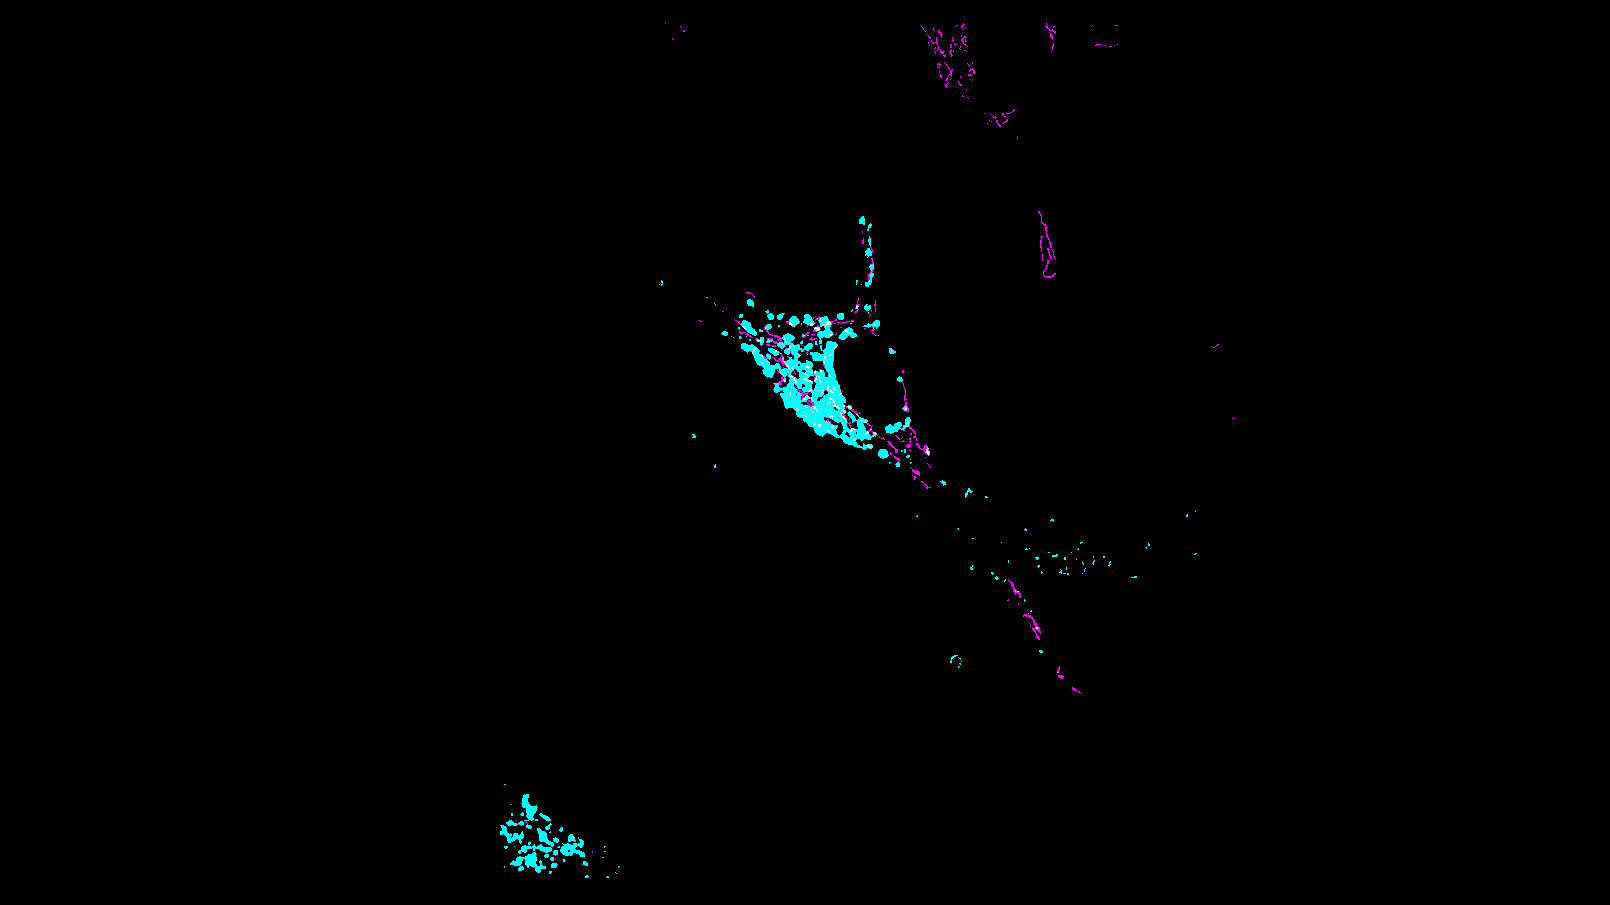

In [24]:
viewer = napari.Viewer()

viewer.add_image(a>0, colormap='cyan', blending ='additive')
viewer.add_image(b>0, colormap='magenta', blending ='additive')
viewer.add_image(test_labels>0, blending ='additive')

nbscreenshot(viewer, canvas_only=True)

In [25]:
viewer.close()

## **`2` - Build the list of measurements we want to include from regionprops and run regionprops**

- assemble list of measurements (morphological properties)

In [26]:
# start with LABEL
test_Xproperties = ["label"]

# add position
test_Xproperties = test_Xproperties + ["centroid", "bbox"]

# add area
test_Xproperties = test_Xproperties + ["area", "equivalent_diameter"] # "num_pixels", 

# add shape measurements - NOTE: can't include minor axis measure because some of the contact sites are only one pixel
test_Xproperties = test_Xproperties + ["extent", "euler_number", "solidity", "axis_major_length", "slice"] # "feret_diameter_max",  , "axis_minor_length"

- create initial regionprops table

In [27]:
## NOTE: it may be worth our time to deal with the measurements that having issues with one voxel objects: 
## axis_min_length - the minimum axis of a voxel should be calulated as the minimum axis of a elipsoid with the same central moment as the voxel;
## when scaling this number should be calculated, but without scale, I think this would just be ~1

test_Xprops = regionprops_table(test_labels, 
                                intensity_image=None, 
                                properties=test_Xproperties, 
                                extra_properties=None, 
                                spacing=scale)

c:\Users\redre\anaconda3\envs\infer-subc-sc\lib\site-packages\skimage\measure\_regionprops.py:430: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 723763888  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  7  Error-roundoff 9.6e-15  _one-merge 6.7e-14
  _near-inside 3.4e-13  Visible-distance 1.9e-14  U-max-coplanar 1.9e-14
  Width-outside 3.9e-14  _wide-facet 1.2e-13  _maxoutside 7.7e-14

  return convex_hull_image(self.image)
c:\Users\redre\anaconda3\envs\infer-subc-sc\lib\site-packages\skimage\measure\_regionprops.py:629: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
c:\Users\redre\anaconda3\envs\infer-subc-sc\lib\site-packages\skimage\measure\_regionprops.py:430: UserWarning: 

In [28]:
test_Xsurface_area_tab = pd.DataFrame(surface_area_from_props(test_labels, test_Xprops, scale=scale))

## **`3` - Track which individual organelles are involved in that interaction**

- identify labels involved in each unique interaction

In [29]:
# collecting a list of organelle IDs associated to each contact site
test_label_a = []
test_index_ab = []
test_label_b = []
for index, lab in enumerate(test_Xprops["label"]):
    # this seems less elegant than you might wish, given that regionprops returns a slice,
    # but we need to expand the slice out by one voxel in each direction, or surface area freaks out
    volume = test_labels[test_Xprops["slice"][index]]
    la = a[test_Xprops["slice"][index]]
    lb = b[test_Xprops["slice"][index]]
    volume = volume == lab
    la = la[volume]
    lb = lb[volume]

    all_as = np.unique(la[la>0]).tolist()
    all_bs = np.unique(lb[lb>0]).tolist()
    if len(all_as) != 1:
        print(f"we have an error.  as-> {all_as}")
    if len(all_bs) != 1:
        print(f"we have an error.  bs-> {all_bs}")

    test_label_a.append(all_as[0])
    test_label_b.append(all_bs[0])
    test_index_ab.append(f"{all_as[0]}_{all_bs[0]}")

> ###### 📝 **The interactions of the mitochondria and lysosomes will be the examples used throughout this notebook**

- correct and add measurements

In [30]:
test_org_a = "lyso"
test_org_b = "mito"

test_Xprops_table = pd.DataFrame(test_Xprops)
test_Xprops_table.drop(columns=["slice", "label"], inplace=True)
test_Xprops_table.insert(0, 'label',value=test_index_ab)
test_Xprops_table.insert(0, "object", f"{test_org_a}X{test_org_b}")
test_Xprops_table.rename(columns={"area": "volume"}, inplace=True)

test_Xprops_table.insert(11, "surface_area", test_Xsurface_area_tab)
test_Xprops_table.insert(13, "SA_to_volume_ratio", test_Xprops_table["surface_area"].div(test_Xprops_table["volume"]))

test_scale = scale

if test_scale is not None:
    test_round_scale = (round(test_scale[0], 4), round(test_scale[1], 4), round(test_scale[2], 4))
    test_Xprops_table.insert(loc=2, column="scale", value=f"{test_round_scale}")
else: 
    test_Xprops_table.insert(loc=2, column="scale", value=f"{tuple(np.ones(test_labels.ndim))}") 

test_Xprops_table

,object,label,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,surface_area,volume,SA_to_volume_ratio,equivalent_diameter,extent,euler_number,solidity,axis_major_length
0,lysoXmito,24_59,"(0.3961, 0.0799, 0.0799)",1.501757,52.848387,63.572828,2,657,784,6,673,808,9.362050,0.473414,19.775616,0.966972,0.121745,1,0.288580,2.341741
1,lysoXmito,173_57,"(0.3961, 0.0799, 0.0799)",1.373115,43.528477,51.539166,3,543,643,5,547,648,1.330494,0.037974,35.036628,0.417027,0.375000,1,0.714286,0.948680
2,lysoXmito,24_106,"(0.3961, 0.0799, 0.0799)",1.557958,46.705037,58.126799,3,580,724,5,589,732,1.710334,0.037974,45.039173,0.417027,0.104167,1,0.652174,1.091644
3,lysoXmito,24_106,"(0.3961, 0.0799, 0.0799)",1.738399,47.275326,57.841655,3,588,722,6,594,726,1.483264,0.045569,32.549674,0.443157,0.250000,1,0.782609,1.117149
4,lysoXmito,24_109,"(0.3961, 0.0799, 0.0799)",1.425928,49.455214,66.451946,3,618,830,5,620,833,0.728682,0.012658,57.566372,0.289150,0.416667,1,0.833333,0.872958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,lysoXmito,24_501,"(0.3961, 0.0799, 0.0799)",5.545274,62.478581,78.228139,14,781,978,15,783,980,0.361894,0.005063,71.474577,0.213048,0.500000,1,inf,0.252815
388,lysoXmito,24_502,"(0.3961, 0.0799, 0.0799)",5.545274,62.718422,78.907689,14,784,987,15,786,988,0.310166,0.005063,61.258355,0.213048,1.000000,1,inf,0.178767
389,lysoXmito,24_506,"(0.3961, 0.0799, 0.0799)",5.941365,57.961575,74.110869,15,725,927,16,726,928,0.180947,0.002532,71.474577,0.169096,1.000000,1,inf,0.000000
390,lysoXmito,24_506,"(0.3961, 0.0799, 0.0799)",5.941365,58.201416,74.270763,15,728,929,16,729,930,0.180947,0.002532,71.474577,0.169096,1.000000,1,inf,0.000000


<!-- #### `WIP`: Adding a "SHELL" measurement for each site of interaction, we want to measure the membrane surface area from each organelle involved in the interaction

I think the most logical way to do this seems to be using marching_cubes to create an isosurface of each object (org A, org B, and the intersection), then cut the orgs' isosurface using the overlap region. The isosurface region of intersection between the org and the overlap will be measured as the membrane in the interaction.

- **shell_aXb**: the "shell", or membrane, of organelle a overlapping with organelle b (*NOTE: shell_aXb and shellbXa are *NOT* redundant*) -->

# ***EXECUTE FUNCTION PROTOTYPE***

## **Define `_get_contact_metrics_3D` function**

Based on the _prototyping_ above define the function to quantify amount, size, and shape of organelles.

In [31]:
def _get_contact_metrics_3D(a: np.ndarray,
                            a_name: str, 
                            b: np.ndarray, 
                            b_name:str, 
                            mask: np.ndarray, 
                            scale: Union[tuple, None]=None,
                            include_dist:bool=False, 
                            dist_centering_obj: Union[np.ndarray, None]=None,
                            dist_num_bins: Union[int, None]=None,
                            dist_zernike_degrees: Union[int, None]=None,
                            dist_center_on: Union[bool, None]=None,
                            dist_keep_center_as_bin: Union[bool, None]=None):
    """
    collect volumentric measurements of organelle `a` intersect organelle `b`

    Parameters
    ------------
    a: np.ndarray
        3D (ZYX) np.ndarray of one set of objects that will be assessed as part of a "contact"
    a_name: str
        the name or nickname of object a; this will be used for record keeping purposed in the output dataframe 
    b: np.ndarray
        3D (ZYX) np.ndarray of one set of objects that will be assessed as part of a "contact"
    b_name: str
        the name or nickname of object b; this will be used for record keeping purposed in the output dataframe 
    mask: np.ndarray
        3D (ZYX) binary mask of the area to measure contacts from
    include_dist:bool=False
        *optional*
        True = include the XY and Z distribution measurements of the contact sites within the masked region 
        (utilizing the functions get_XY_distribution() and get_Z_distribution() from Infer-subc)
        False = do not include distirbution measurements
    dist_centering_obj: Union[np.ndarray, None]=None
        ONLY NEEDED IF include_dist=True; if None, the center of the mask will be used
        3D (ZYX) np.ndarray containing the object to use for centering the XY distribution mask
    dist_num_bins: Union[int, None]=None
        ONLY NEEDED IF include_dist=True; if None, the default is 5
    dist_zernike_degrees: Unions[int, None]=None,
        ONLY NEEDED IF include_dist=True; if None, the zernike share measurements will not be included in the distribution
        the number of zernike degrees to include for the zernike shape descriptors
    dist_center_on: Union[bool, None]=None
        ONLY NEEDED IF include_dist=True; if None, the default is False
        True = distribute the bins from the center of the centering object
        False = distribute the bins from the edge of the centering object
    dist_keep_center_as_bin: Union[bool, None]=None
        ONLY NEEDED IF include_dist=True; if None, the default is True
        True = include the centering object area when creating the bins
        False = do not include the centering object area when creating the bins


    Regionprops measurements:
    ------------------------
    ['label',
    'centroid',
    'bbox',
    'area',
    'equivalent_diameter',
    'extent',
    'feret_diameter_max',
    'euler_number',
    'convex_area',
    'solidity',
    'axis_major_length',
    'axis_minor_length']

    Additional measurements:
    ----------------------
    ['surface_area']

    
    Returns
    -------------
    pandas dataframe of containing regionprops measurements (columns) for each overlap region between a and b (rows)
    
    """
    
    #########################
    ## CREATE OVERLAP REGIONS
    #########################
    a = _assert_uint16_labels(a)
    b = _assert_uint16_labels(b)

    a_int_b = np.logical_and(a > 0, b > 0)

    labels = label(apply_mask(a_int_b, mask)).astype("int")

    ##########################################
    ## CREATE LIST OF REGIONPROPS MEASUREMENTS
    ##########################################
    # start with LABEL
    properties = ["label"]

    # add position
    properties = properties + ["centroid", "bbox"]

    # add area
    properties = properties + ["area", "equivalent_diameter"] # "num_pixels", 

    # add shape measurements
    properties = properties + ["extent", "euler_number", "solidity", "axis_major_length", "slice"] # "feret_diameter_max", "axis_minor_length", 

    ##################
    ## RUN REGIONPROPS
    ##################
    props = regionprops_table(labels, intensity_image=None, properties=properties, extra_properties=None, spacing=scale)

    ##################################################################
    ## RUN SURFACE AREA FUNCTION SEPARATELY AND APPEND THE PROPS_TABLE
    ##################################################################
    surface_area_tab = pd.DataFrame(surface_area_from_props(labels, props, scale))

    ######################################################
    ## LIST WHICH ORGANELLES ARE INVOLVED IN THE CONTACTS
    ######################################################
    label_a = []
    index_ab = []
    label_b = []
    for index, lab in enumerate(props["label"]):
        # this seems less elegant than you might wish, given that regionprops returns a slice,
        # but we need to expand the slice out by one voxel in each direction, or surface area freaks out
        volume = labels[props["slice"][index]]
        la = a[props["slice"][index]]
        lb = b[props["slice"][index]]
        volume = volume == lab
        la = la[volume]
        lb = lb[volume]

        all_as = np.unique(la[la>0]).tolist()
        all_bs = np.unique(lb[lb>0]).tolist()
        if len(all_as) != 1:
            print(f"we have an error.  as-> {all_as}")
        if len(all_bs) != 1:
            print(f"we have an error.  bs-> {all_bs}")

        label_a.append(f"{all_as[0]}" )
        label_b.append(f"{all_bs[0]}" )
        index_ab.append(f"{all_as[0]}_{all_bs[0]}")


    ######################################################
    ## CREATE COMBINED DATAFRAME OF THE QUANTIFICATION
    ######################################################
    props_table = pd.DataFrame(props)
    props_table.drop(columns=['slice', 'label'], inplace=True)
    props_table.insert(0, 'label',value=index_ab)
    props_table.insert(0, "object", f"{a_name}X{b_name}")
    props_table.rename(columns={"area": "volume"}, inplace=True)

    props_table.insert(11, "surface_area", surface_area_tab)
    props_table.insert(13, "SA_to_volume_ratio", props_table["surface_area"].div(props_table["volume"]))

    if scale is not None:
        round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
        props_table.insert(loc=2, column="scale", value=f"{round_scale}")
    else: 
        props_table.insert(loc=2, column="scale", value=f"{tuple(np.ones(labels.ndim))}") 


    ######################################################
    ## optional: DISTRIBUTION OF CONTACTS MEASUREMENTS
    ######################################################
    if include_dist is True:
        XY_contact_dist, XY_bins, XY_wedges = get_XY_distribution(mask=mask, 
                                                                  obj=a_int_b,
                                                                  obj_name=f"{a_name}X{b_name}",
                                                                  centering_obj=dist_centering_obj,
                                                                  scale=scale,
                                                                  center_on=dist_center_on,
                                                                  keep_center_as_bin=dist_keep_center_as_bin,
                                                                  num_bins=dist_num_bins,
                                                                  zernike_degrees=dist_zernike_degrees)
        
        Z_contact_dist = get_Z_distribution(mask=mask,
                                            obj=a_int_b,
                                            obj_name=f"{a_name}X{b_name}",
                                            center_obj=dist_centering_obj,
                                            scale=scale)
        
        contact_dist_tab = pd.merge(XY_contact_dist, Z_contact_dist, on=["object", "scale"])

        return props_table, contact_dist_tab
    else:
        return props_table

## **Run `_get_contact_metrics_3D` function (scaled)**

In [32]:
lysoXmito_stat_tab_test, test_cont_dist_tab = _get_contact_metrics_3D(a=lyso_seg, a_name='lyso', 
                                                                      b=mito_seg, b_name='mito', 
                                                                      mask=cell_seg, 
                                                                      scale=scale,
                                                                      include_dist=True, 
                                                                      dist_centering_obj=nuc_seg,
                                                                      dist_center_on=False,
                                                                      dist_keep_center_as_bin=True,
                                                                      dist_num_bins=5,
                                                                      dist_zernike_degrees=9)

lysoXmito_stat_tab_test.equals(test_Xprops_table)

c:\Users\redre\anaconda3\envs\infer-subc-sc\lib\site-packages\skimage\measure\_regionprops.py:430: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 723831116  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  7  Error-roundoff 9.6e-15  _one-merge 6.7e-14
  _near-inside 3.4e-13  Visible-distance 1.9e-14  U-max-coplanar 1.9e-14
  Width-outside 3.9e-14  _wide-facet 1.2e-13  _maxoutside 7.7e-14

  return convex_hull_image(self.image)
c:\Users\redre\anaconda3\envs\infer-subc-sc\lib\site-packages\skimage\measure\_regionprops.py:629: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
c:\Users\redre\anaconda3\envs\infer-subc-sc\lib\site-packages\skimage\measure\_regionprops.py:430: UserWarning: 

True

In [33]:
test_cont_dist_tab

,object,scale,XY_n_bins,XY_bins,XY_mask_vox_cnt_perbin,XY_obj_vox_cnt_perbin,XY_center_vox_cnt_perbin,XY_n_pix_perbin,XY_portion_pix_perbin,XY_n_wedges,...,zernike_center_phs,Z_n_slices,Z_slices,Z_mask_vox_cnt,Z_obj_vox_cnt,Z_center_vox_cnt,Z_height,Z_mask_volume,Z_obj_volume,Z_center_volume
0,lysoXmito,"(0.3961, 0.0799, 0.0799)",5,"[1, 2, 3, 4, 5]","[217355, 95389, 135234, 192049, 383969]","[977, 4226, 5978, 5912, 3718]","[79970, 0, 0, 0, 0]","[15534.0, 7146.0, 10646.0, 17048.0, 68991.0]","[0.13013865035814517, 0.05986679512419889, 0.0...",8,...,"[1.5707963267948966, -2.7370885998619583, -1.5...",18,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 7572, 64134, 76764, 81590, 89670, 98309...","[0, 0, 1, 166, 1373, 2712, 3041, 2571, 2447, 1...","[0, 0, 0, 0, 0, 0, 0, 9607, 13937, 14701, 1455...",7.129638,"[0.0, 0.0, 19.1694619326348, 162.3632160047015...","[0.0, 0.0, 0.0025316246609396196, 0.4202496937...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.3213181..."


## **Compare to finalized `get_contact_metrics_3D` function**

In [34]:
from infer_subc.utils.stats import get_contact_metrics_3D

lysoXmito_stat_tab_final, test_cont_dist_tab_final = get_contact_metrics_3D(a=lyso_seg, a_name='lyso', 
                                                                      b=mito_seg, b_name='mito', 
                                                                      mask=cell_seg, 
                                                                      scale=scale,
                                                                      include_dist=True, 
                                                                      dist_centering_obj=nuc_seg,
                                                                      dist_center_on=False,
                                                                      dist_keep_center_as_bin=True,
                                                                      dist_num_bins=5,
                                                                      dist_zernike_degrees=9)

lysoXmito_stat_tab_test.equals(lysoXmito_stat_tab_final), test_cont_dist_tab.equals(test_cont_dist_tab_final)

c:\Users\redre\anaconda3\envs\infer-subc-sc\lib\site-packages\skimage\measure\_regionprops.py:430: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 724015993  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  7  Error-roundoff 9.6e-15  _one-merge 6.7e-14
  _near-inside 3.4e-13  Visible-distance 1.9e-14  U-max-coplanar 1.9e-14
  Width-outside 3.9e-14  _wide-facet 1.2e-13  _maxoutside 7.7e-14

  return convex_hull_image(self.image)
c:\Users\redre\anaconda3\envs\infer-subc-sc\lib\site-packages\skimage\measure\_regionprops.py:629: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
c:\Users\redre\anaconda3\envs\infer-subc-sc\lib\site-packages\skimage\measure\_regionprops.py:430: UserWarning: 

(True, True)